# Deep Learning Bootcamp November 2017, GPU Computing for Data Scientists

<img src="../images/bcamp.png" align="center">

## 21 PyTorch CIFAR-10 Custom data loader from scratch

Web: https://www.meetup.com/Tel-Aviv-Deep-Learning-Bootcamp/events/241762893/

Notebooks: <a href="https://github.com/QuantScientist/Data-Science-PyCUDA-GPU"> On GitHub</a>

*Shlomo Kashani*

<img src="../images/pt.jpg" width="35%" align="center">

#### References:

- http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

- https://www.bountysource.com/issues/44576966-a-tutorial-on-writing-custom-datasets-samplers-and-using-transforms

- https://medium.com/towards-data-science/my-first-kaggle-competition-9d56d4773607

- https://github.com/sohyongsheng/kaggle-planet-forest

- https://github.com/rwightman/pytorch-planet-amazon/blob/master/dataset.py




# PyTorch Imports


In [297]:
# !pip install pycuda
%reset -f
import numpy
import numpy as np
from __future__ import print_function
from __future__ import division
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MultiLabelBinarizer
import time
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (6, 6)      # setting default size of plots
import tensorflow as tf 
print("tensorflow:" + tf.__version__)
!set "KERAS_BACKEND=tensorflow"
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# !pip install http://download.pytorch.org/whl/cu75/torch-0.2.0.post1-cp27-cp27mu-manylinux1_x86_64.whl
# !pip install torchvision 
# ! pip install cv2
# import cv2
import logging
handler=logging.basicConfig(level=logging.INFO)
lgr = logging.getLogger(__name__)


tensorflow:1.2.1
__Python VERSION: 2.7.12 (default, Nov 19 2016, 06:48:10) 
[GCC 5.4.0 20160609]
__pyTorch VERSION: 0.1.12+4eb448a
__CUDA VERSION
__CUDNN VERSION: 5110
__Number CUDA Devices: 1
__Devices


In [298]:
# Torch CPU
# !pip install http://download.pytorch.org/whl/cu75/torch-0.2.0.post1-cp27-cp27mu-manylinux1_x86_64.whl
# !pip install torchvision 


## CUDA Trick

In [299]:
use_cuda = torch.cuda.is_available()
# use_cuda = False

FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

# Setting up global variables

- Root folder
- Image folder
- Image Label folder

In [300]:
! df -k

DATA_ROOT ='/root/data/cifar/'
IMG_PATH = DATA_ROOT + '/train/'
IMG_EXT = '.png'
IMG_DATA_LABELS = DATA_ROOT + '/trainLabels.csv'

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Filesystem     1K-blocks      Used Available Use% Mounted on
none           894819992 226110676 623232044  27% /
tmpfs           32943896         0  32943896   0% /dev
tmpfs           32943896         0  32943896   0% /sys/fs/cgroup
/dev/sda2      894819992 226110676 623232044  27% /root/data
shm                65536      1264     64272   2% /dev/shm
tmpfs           32943896         0  32943896   0% /sys/firmware


# The Torch Dataset Class

In [301]:
try:
    from PIL import Image
except ImportError:
    import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from collections import defaultdict


class GenericImageDataset(Dataset):    
    def __init__(self, csv_path, img_path, img_ext, transform=None):                
        t = time.time()        
        lgr.info('CSV path {}'.format(csv_path))
        lgr.info('IMG path {}'.format(img_path))                
        assert img_ext in ['.png']
        
        self.transform=transform
        tmp_df = pd.read_csv(csv_path, header=None) # I manually removed the header
        
        self.img_path = img_path
        self.img_ext = img_ext        
        
        # Encoding the variables
        d = defaultdict(LabelEncoder)
        tmp_df = tmp_df.apply(lambda x: d[x.name].fit_transform(x))
        
        lgr.info("DF CSV:\n" + str (tmp_df.head(5)))
            
        self.X_train = tmp_df[0]                
        self.y_train = tmp_df[1]
        
        lgr.info("DF X_train:\n" + str (self.X_train.head(5)))
        lgr.info ("DF y_train:\n" + str(self.y_train.head(5)))        
        lgr.info('[*] Dataset loading time {}'.format(time.time() - t))
        lgr.info('[*] Data size is {}'.format(len(self)))

    def __getitem__(self, index):
        
        path=self.img_path + str(self.X_train[index]) + self.img_ext            
        img = Image.open(path)
        if self.transform is not None:                                     
            img = self.transform(img)            
#         label = self.y_train[index]
        label = (self.y_train[index])
#         lgr.info ("__getitem__:" + str(index) + " Label:" + str(label))
        return img, label

    def __len__(self):
        l=len(self.X_train.index)
        return (l)       

    @staticmethod        
    def imshow(img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

    @staticmethod    
    def flaotTensorToImage(img, mean=0, std=1):
        """convert a tensor to an image"""
        img = np.transpose(img.numpy(), (1, 2, 0))
        img = (img*std+ mean)*255
        img = img.astype(np.uint8)    
        return img    
    
    @staticmethod
    def toTensor(img):
        """convert a numpy array of shape HWC to CHW tensor"""
        img = img.transpose((2, 0, 1)).astype(np.float32)
        tensor = torch.from_numpy(img).float()
        return tensor/255.0

# The Torch transforms.ToTensor() methood

- Converts: a PIL.Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].

In [302]:
# transformations = transforms.Compose([transforms.ToTensor()])
transformations = transforms.Compose([transforms.Scale(32),transforms.ToTensor()])

In [303]:
dset_train = GenericImageDataset(IMG_DATA_LABELS,
                                 IMG_PATH,
                                 IMG_EXT,transformations)

INFO:__main__:CSV path /root/data/cifar//trainLabels.csv
INFO:__main__:IMG path /root/data/cifar//train/
INFO:__main__:DF CSV:
   0  1
0  0  6
1  1  6
2  2  9
3  3  9
4  4  4
INFO:__main__:DF X_train:
0    0
1    1
2    2
3    3
4    4
Name: 0, dtype: int64
INFO:__main__:DF y_train:
0    6
1    6
2    9
3    9
4    4
Name: 1, dtype: int64
INFO:__main__:[*] Dataset loading time 0.0405609607697
INFO:__main__:[*] Data size is 50001


# Train Validation Split

- Since there is no train_test_split method in PyTorcj, we have to split a TRAINNING dataset into training and validation sets.

In [304]:
validationRatio=0.22    
batch_size=4

class FullTrainingDataset(torch.utils.data.Dataset):
    def __init__(self, full_ds, offset, length):
        self.full_ds = full_ds
        self.offset = offset
        self.length = length
        assert len(full_ds)>=offset+length, Exception("Parent Dataset not long enough")
        super(FullTrainingDataset, self).__init__()
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, i):
        return self.full_ds[i+self.offset]
    
def trainTestSplit(dataset, val_share=validationRatio):
    val_offset = int(len(dataset)*(1-val_share))
    return FullTrainingDataset(dataset, 0, val_offset), FullTrainingDataset(dataset, val_offset, len(dataset)-val_offset)

 
train_ds, val_ds = trainTestSplit(dset_train)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=2)

# Test the DataLoader Class

INFO:__main__:i=0: 
INFO:__main__:i=1: 
INFO:__main__:i=2: 
INFO:__main__:i=3: 


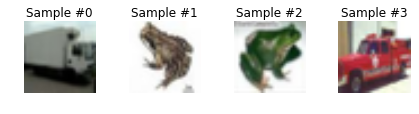

In [305]:
imagesToShow=4

for i, data in enumerate(train_loader, 0):
    lgr.info('i=%d: '%(i))            
    images, labels = data            
    num = len(images)
    
    ax = plt.subplot(1, imagesToShow, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    
    for n in range(num):
        image=images[n]
        label=labels[n]
        plt.imshow (GenericImageDataset.flaotTensorToImage(image))
        
    if i==imagesToShow-1:
        break    

INFO:__main__:i=0: 
INFO:__main__:i=1: 
INFO:__main__:i=2: 
INFO:__main__:i=3: 


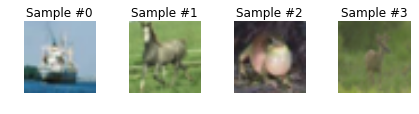

In [306]:
for i, data in enumerate(val_loader, 0):
    lgr.info('i=%d: '%(i))            
    images, labels = data            
    num = len(images)
    
    ax = plt.subplot(1, imagesToShow, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    
    for n in range(num):
        image=images[n]
        label=labels[n]
        plt.imshow (GenericImageDataset.flaotTensorToImage(image))
        
    if i==imagesToShow-1:
        break    

# The NN model

In [307]:
class Net(nn.Module):
    def __init__(self,initKernel='uniform'):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
         # xavier initializer
        if initKernel == 'uniform':
            nn.init.xavier_uniform(self.conv1.weight, gain=np.sqrt(2.0))
#             nn.init.xavier_uniform(self.conv2.weight, gain=np.sqrt(2.0))
        else:
            nn.init.kaiming_normal(self.conv1.weight)   
#             nn.init.kaiming_normal(self.conv2.weight)   
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x        
if use_cuda:
    lgr.info ("Using the GPU")
    model = Net().cuda() # On GPU
else:
    lgr.info ("Using the CPU")
    model = Net() # On CPU

lgr.info('Model {}'.format(model))



INFO:__main__:Using the GPU
INFO:__main__:Model Net (
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (400 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)


#  Loss and Optimizer

- Select a loss function and the optimization algorithm.

- if return F.log_softmax(x) then loss = F.nll_loss(output, target) (MNIST)



In [308]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.SGD(model.parameters(), lr=1e-1,momentum=0.9, weight_decay=1e-4)
lgr.info('Optimizer {}'.format(optimizer))

# criterion = nn.ClassNLLCriterion() -- a negative log-likelihood criterion for multi-class classification
criterion = nn.CrossEntropyLoss()
lgr.info('Loss function {}'.format(criterion))

INFO:__main__:Optimizer <torch.optim.sgd.SGD object at 0x7ff58b976d10>
INFO:__main__:Loss function CrossEntropyLoss (
)


# Start training in Batches

See example here:
http://codegists.com/snippet/python/pytorch_mnistpy_kernelmode_python

https://github.com/pytorch/examples/blob/53f25e0d0e2710878449900e1e61d31d34b63a9d/mnist/main.py

Epoch 1


INFO:__main__:Train Epoch: 1 [0/39000 (0%)]	Loss: 1.472729


[2,     4] loss: 1.026


INFO:__main__:Train Epoch: 1 [12000/39000 (31%)]	Loss: 0.799937


[2,     4] loss: 1.021


INFO:__main__:Train Epoch: 1 [24000/39000 (62%)]	Loss: 0.486916


[2,     4] loss: 1.032
[2,     4] loss: 1.048


INFO:__main__:Train Epoch: 1 [36000/39000 (92%)]	Loss: 2.216398


Finished Training epoch:1
Epoch 2


INFO:__main__:Train Epoch: 2 [0/39000 (0%)]	Loss: 0.123995


[3,     4] loss: 0.955


INFO:__main__:Train Epoch: 2 [12000/39000 (31%)]	Loss: 1.046829


[3,     4] loss: 0.965


INFO:__main__:Train Epoch: 2 [24000/39000 (62%)]	Loss: 0.468068


[3,     4] loss: 1.019
[3,     4] loss: 0.994


INFO:__main__:Train Epoch: 2 [36000/39000 (92%)]	Loss: 2.045724


Finished Training epoch:2
Epoch 3


INFO:__main__:Train Epoch: 3 [0/39000 (0%)]	Loss: 2.138162


[4,     4] loss: 0.913


INFO:__main__:Train Epoch: 3 [12000/39000 (31%)]	Loss: 0.921681


[4,     4] loss: 0.937


INFO:__main__:Train Epoch: 3 [24000/39000 (62%)]	Loss: 0.511757


[4,     4] loss: 0.972
[4,     4] loss: 0.941


INFO:__main__:Train Epoch: 3 [36000/39000 (92%)]	Loss: 0.487584


Finished Training epoch:3
Epoch 4


INFO:__main__:Train Epoch: 4 [0/39000 (0%)]	Loss: 1.247653


[5,     4] loss: 0.875


INFO:__main__:Train Epoch: 4 [12000/39000 (31%)]	Loss: 0.723596


[5,     4] loss: 0.907


INFO:__main__:Train Epoch: 4 [24000/39000 (62%)]	Loss: 0.667364


[5,     4] loss: 0.923
[5,     4] loss: 0.948


INFO:__main__:Train Epoch: 4 [36000/39000 (92%)]	Loss: 2.277793


Finished Training epoch:4


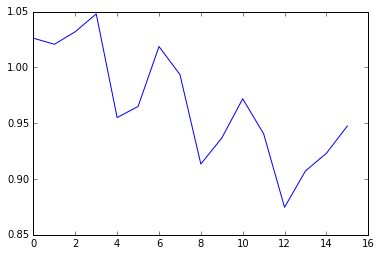

In [310]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
 
loss_history = []
acc_history = []
running_loss = 0.0

def train(epoch):
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader): #  
        # torch.LongTensor of size BATCH_SIZE
        # [torch.FloatTensor of size 4x3x32x32] BATCH_SIZE* IMAGE SIZE
        if use_cuda:
            data, target = Variable(data.cuda(async=True)), Variable(target.cuda(async=True)) # On GPU                
        else:            
            data, target = Variable(data), Variable(target) 
            # You will get RuntimeError: expected CPU tensor (got CUDA tensor) if you dont do this 
        optimizer.zero_grad()        
        outputs = model(data)
        if use_cuda:
            loss = criterion(outputs, target).cuda()            
        else:
            loss = criterion(outputs, target)

        loss.backward()
        optimizer.step()        
        running_loss += loss.data[0]
        if batch_idx % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            loss_history.append(running_loss / 2000)
            running_loss = 0.0
        
        if batch_idx % 3000 == 0:
            # loss_history.append(loss.data[0])
            lgr.info('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.data[0]))       
            
start_time = time.time()    

for epoch in range(1, 5):
    print("Epoch %d" % epoch)
    train(epoch)    
    print('Finished Training epoch:' + str(epoch))
end_time = time.time()


# Plot LOG_LOSS

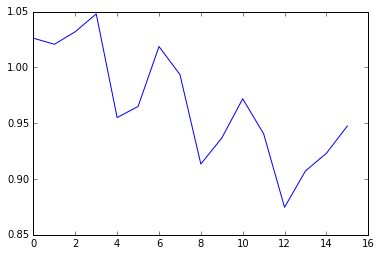

In [353]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.show()

# Validate the model on a small sample of images


 8
 7
 0
 2
[torch.LongTensor of size 4]

GroundTruth:   ship horse plane  bird
[[8]
 [7]
 [0]
 [5]]
<type 'numpy.ndarray'>
ship
horse
plane
dog


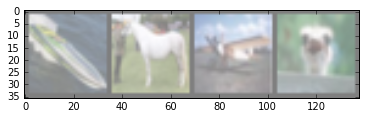

In [368]:
import torchvision
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))    
    
dataiter = iter(val_loader)
images, labels = dataiter.next()
print (labels)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

if use_cuda:
    images = Variable(images.cuda(async=True))
else:            
    images= Variable(images)
            
outputs = model(images)

_, predicted = torch.max(outputs.data, 1)
predicted=predicted.cpu().numpy()
print (predicted)
print (type(predicted))

for y in np.nditer(predicted, op_flags=['readwrite']):
    print (classes[y])                

In [367]:
correct = 0
total = 0

for data in val_loader:
    images, labels = data
    
if use_cuda:
    outputs = model(Variable(images.cuda(async=True)))
else:            
    outputs = model(Variable(images))                
    
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print ("Total:"  +  str (total))    
print ("correct:" + str (correct))    

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))


Total:0
correct:0


ZeroDivisionError: division by zero

In [334]:
%%bash
jupyter nbconvert \
    --to=slides \
    --reveal-prefix=https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.2.0/ \
    --output=py09.html \
    './09 PyTorch Kaggle Image Data-set loading with CNN'

/usr/local/lib/python2.7/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)
[NbConvertApp] Converting notebook ./09 PyTorch Kaggle Image Data-set loading with CNN.ipynb to slides
[NbConvertApp] Writing 394699 bytes to ./py09.html.slides.html
